<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 5260, 'maxbars': 100000, 'codepage': 0, 'ping_last':

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True and terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [ ]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "USD" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

280
Yes  EURUSD
Yes  GBPUSD
Yes  USDJPY
Yes  USDCHF
Yes  AUDUSD
Yes  NZDUSD
Yes  USDCAD
Yes  USDMXN
Yes  USDZAR
Yes  XAGUSD
Yes  XAUUSD
Yes  XBRUSD
Yes  XTIUSD
Yes  XNGUSD
Yes  BTCUSD
Yes  ETHUSD
Yes  LTCUSD
Yes  XRPUSD
Yes  BCHUSD
Yes  AAVEUSD
Yes  ADAUSD
Yes  ALGOUSD
Yes  ATOMUSD
Yes  AVAXUSD
Yes  AXSUSD
Yes  BNBUSD
Yes  DASHUSD
Yes  DOGEUSD
Yes  DOTUSD
Yes  FILUSD
Yes  GRTUSD
Yes  ICPUSD
Yes  IOTAUSD
Yes  LINKUSD
Yes  LRCUSD
Yes  MANAUSD
Yes  NEARUSD
Yes  SOLUSD
Yes  UNIUSD
Yes  ZECUSD
Yes  ETCUSD
Yes  TRXUSD
Yes  FETUSD
Yes  ARBUSD
Yes  APTUSD
Yes  SUIUSD
Yes  USDDKK
Yes  USDCZK
Yes  USDHUF
Yes  USDNOK
Yes  USDPLN
Yes  USDSEK
Yes  USDSGD
Yes  USDHKD
Yes  USDCNH
Yes  USDTRY
Yes  XBRUSD.Daily
Yes  XTIUSD.Daily
Yes  BTCUSD.Daily
Yes  ETHUSD.Daily
Yes  XRPUSD.Daily
Yes  LTCUSD.Daily
Yes  BCHUSD.Daily
Yes  LINKUSD.Daily
Yes  SOLUSD.Daily
65


In [ ]:
test_symbol = []
for t_s in t_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_H1, 0, 99999)
    if(len(market) > 80000):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" dbot.csv", index=False)
        test_symbol.append(t_s)


In [ ]:

for t_s in test_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_D1, 0, 1000)
    if(len(market) > 900):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" test.csv", index=False)



NameError: name 'test_symbol' is not defined

In [ ]:
import joblib

joblib.dump(t_symbol,"symbol.joblib")

['symbol.joblib']

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import joblib
import os
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

In [4]:
# Get the list of all files and directories in the specified path

dir_contents = os.listdir(".")
t_symbol = joblib.load("symbol.joblib")

In [5]:
print(t_symbol)

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCHF', 'AUDUSD', 'NZDUSD', 'USDCAD', 'USDMXN', 'USDZAR', 'XAGUSD', 'XAUUSD', 'XBRUSD', 'XTIUSD', 'XNGUSD', 'BTCUSD', 'ETHUSD', 'LTCUSD', 'XRPUSD', 'BCHUSD', 'AAVEUSD', 'ADAUSD', 'ALGOUSD', 'ATOMUSD', 'AVAXUSD', 'AXSUSD', 'BNBUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'FILUSD', 'GRTUSD', 'ICPUSD', 'IOTAUSD', 'LINKUSD', 'LRCUSD', 'MANAUSD', 'NEARUSD', 'SOLUSD', 'UNIUSD', 'ZECUSD', 'ETCUSD', 'TRXUSD', 'FETUSD', 'ARBUSD', 'APTUSD', 'SUIUSD', 'USDDKK', 'USDCZK', 'USDHUF', 'USDNOK', 'USDPLN', 'USDSEK', 'USDSGD', 'USDHKD', 'USDCNH', 'USDTRY', 'XBRUSD.Daily', 'XTIUSD.Daily', 'BTCUSD.Daily', 'ETHUSD.Daily', 'XRPUSD.Daily', 'LTCUSD.Daily', 'BCHUSD.Daily', 'LINKUSD.Daily', 'SOLUSD.Daily']


In [6]:

# Filter the list to include only files, not directories
# os.path.join is used to create a full path for isfile() to check
files = [item for item in dir_contents]

file_target = []
test_target = []

for filename in files:
    for t_s in t_symbol:
        if t_s in filename  and "dbot.csv" in filename:
            print(filename)
            file_target.append(filename)
            test_target.append(filename.replace("dbot","test"))

print("----------------------------------------------------")

print(len(file_target))
print(len(test_target))
train_dfs = []
for f_t in file_target:
    train_dfs.append(pd.read_csv(f_t))

train_dfs_test = []
for f_t in test_target:
    train_dfs_test.append(pd.read_csv(f_t))

GeneratedAUDUSD dbot.csv
GeneratedEURUSD dbot.csv
GeneratedGBPUSD dbot.csv
GeneratedNZDUSD dbot.csv
GeneratedUSDCAD dbot.csv
GeneratedUSDCHF dbot.csv
GeneratedUSDJPY dbot.csv
GeneratedUSDMXN dbot.csv
GeneratedUSDZAR dbot.csv
----------------------------------------------------
9
9


In [7]:
display(train_dfs[0])

,open,high,low,close
0,0.82700,0.82775,0.82576,0.82644
1,0.82645,0.82850,0.82639,0.82680
2,0.82679,0.82769,0.82654,0.82684
3,0.82683,0.82764,0.82450,0.82462
4,0.82464,0.82557,0.82336,0.82547
...,...,...,...,...
99994,0.65673,0.65695,0.65603,0.65630
99995,0.65629,0.65629,0.65535,0.65549
99996,0.65550,0.65557,0.65494,0.65516
99997,0.65515,0.65544,0.65494,0.65517


In [8]:
display(train_dfs_test[0])

,open,high,low,close
0,0.72720,0.72907,0.72266,0.72277
1,0.72301,0.72730,0.72204,0.72221
2,0.72217,0.72359,0.72062,0.72254
3,0.72225,0.72271,0.71835,0.71930
4,0.71912,0.72088,0.71775,0.71867
...,...,...,...,...
995,0.65441,0.65593,0.65343,0.65516
996,0.65498,0.65578,0.64824,0.65187
997,0.65172,0.65536,0.65015,0.65414
998,0.65401,0.65490,0.65005,0.65163


In [9]:
print(train_dfs[0].values[:,-1:])

[[0.82644]
 [0.8268 ]
 [0.82684]
 ...
 [0.65516]
 [0.65517]
 [0.65546]]


In [10]:
def create_sequences(data_scaled, seq_len):
    """
    data_scaled: np.array shaped (n_rows, n_features)
    returns X (n_samples, seq_len, n_features), y (n_samples, n_features)
    where y is the row immediately following the window.
    """
    X, y = [], []
    n_rows = data_scaled.shape[0]
    for i in range(n_rows - seq_len):
        X.append(data_scaled[i:i+seq_len])
        y.append(data_scaled[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    return X, y





GeneratedAUDUSD 
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 200)           161600    
                                                                 
 lstm_5 (LSTM)               (None, 60, 200)           320800    
                                                                 
 lstm_6 (LSTM)               (None, 60, 200)           320800    
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 dropout_1 (Dropout)         (None, 150)  

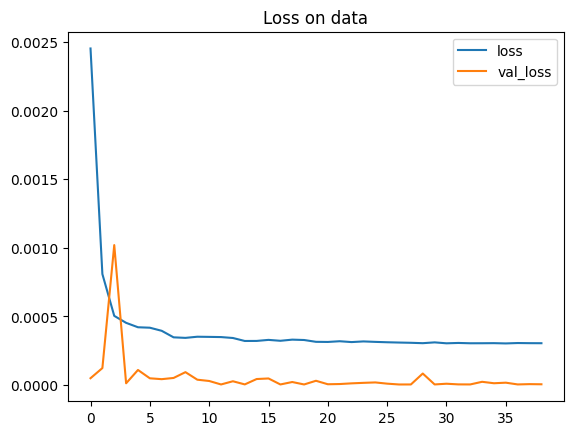

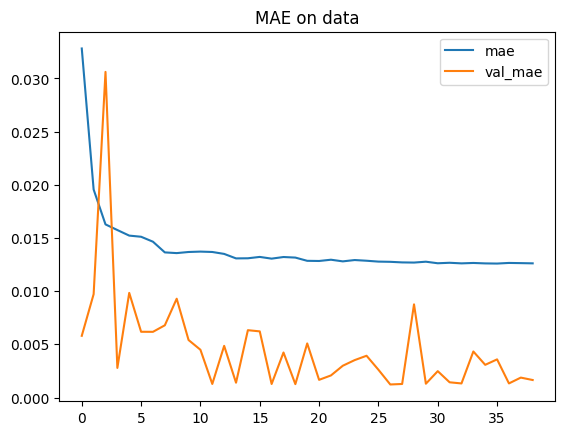

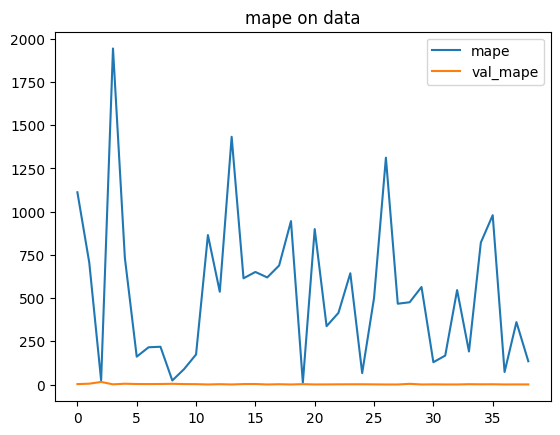

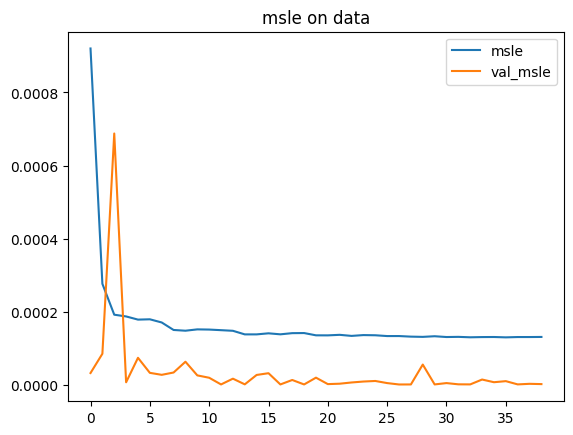

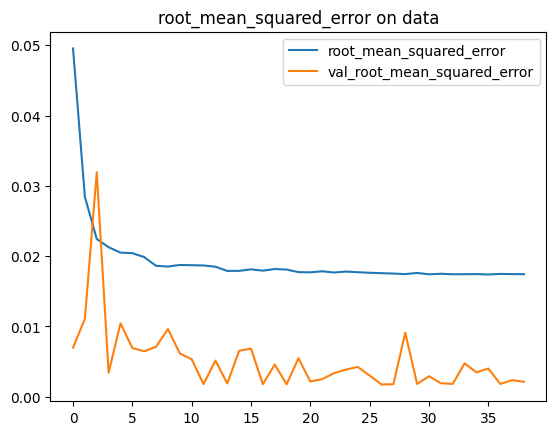

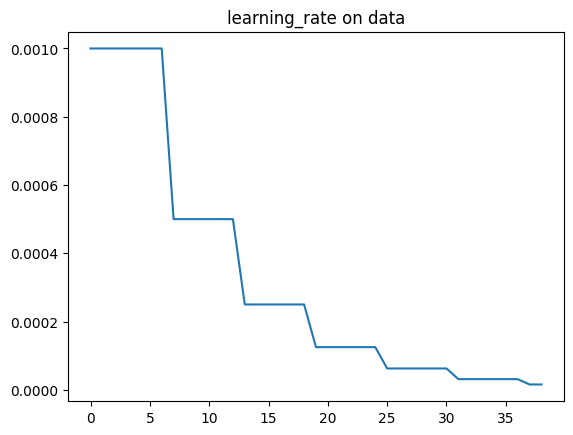

11/11 [==============================] - 1s 21ms/step
R^2 value for  GeneratedAUDUSD 
0.9678596345031056


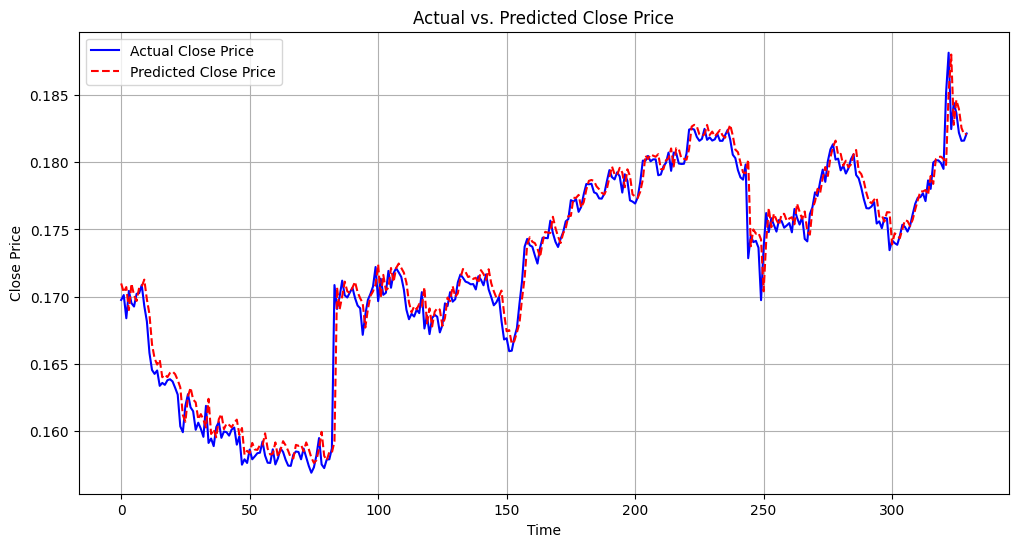

3124/3124 [==============================] - 33s 11ms/step
R^2 value for test  GeneratedAUDUSD 
0.9999145329861795


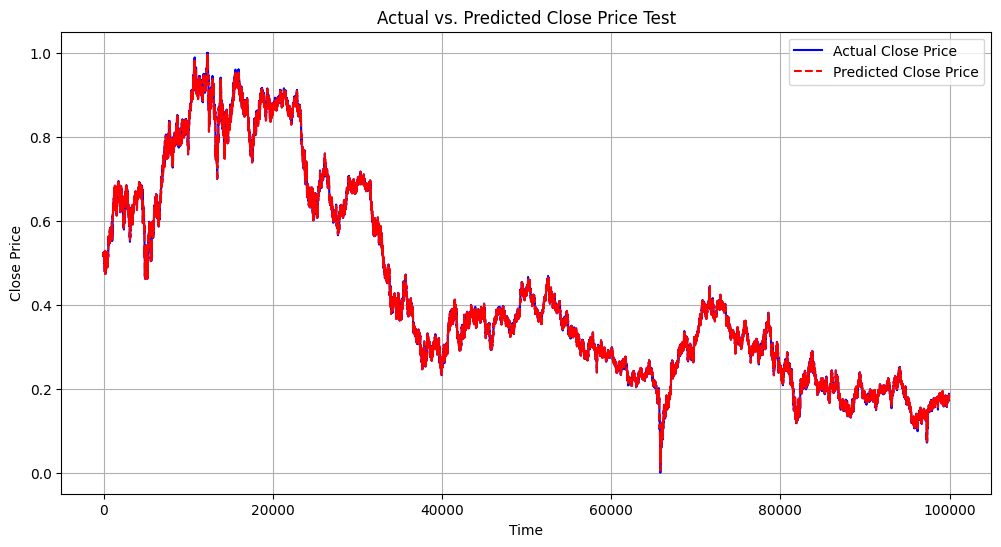

GeneratedEURUSD 
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 200)           161600    
                                                                 
 lstm_9 (LSTM)               (None, 60, 200)           320800    
                                                                 
 lstm_10 (LSTM)              (None, 60, 200)           320800    
                                                                 
 lstm_11 (LSTM)              (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 150)               30150     
                                                                 
 dropout_2 (Dropout)         (None, 150)  

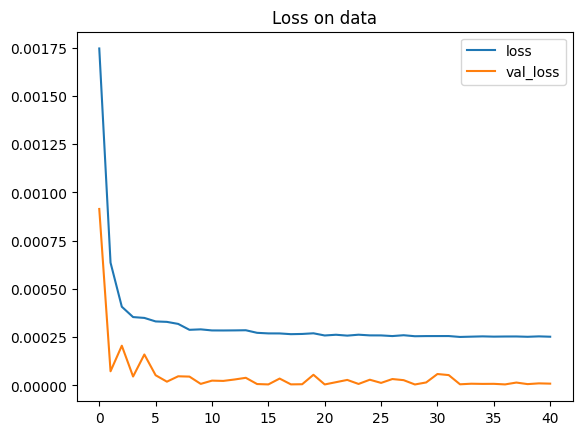

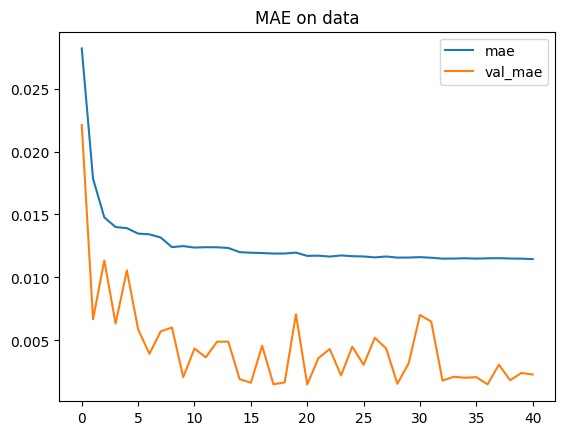

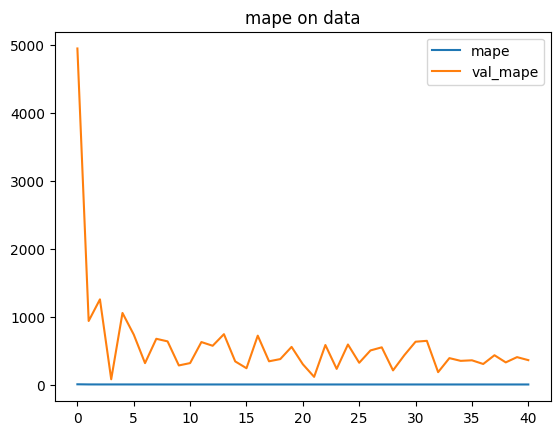

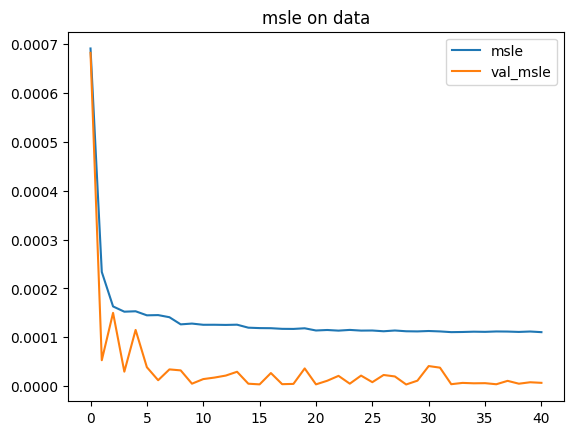

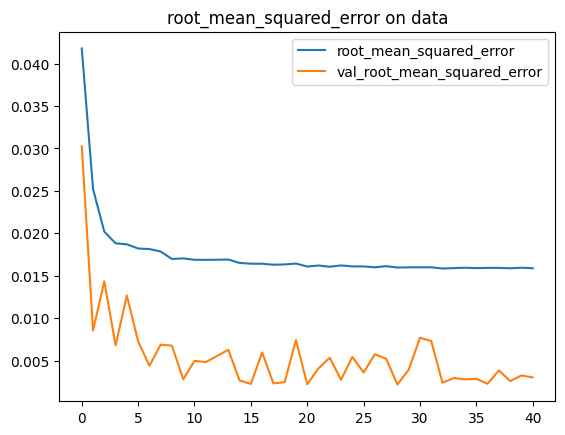

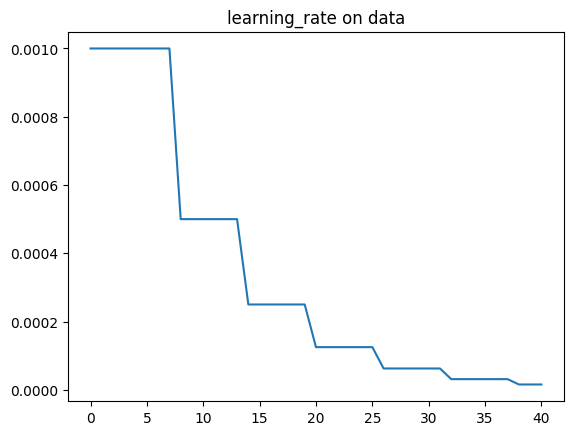

11/11 [==============================] - 1s 18ms/step
R^2 value for  GeneratedEURUSD 
0.8795788609463344


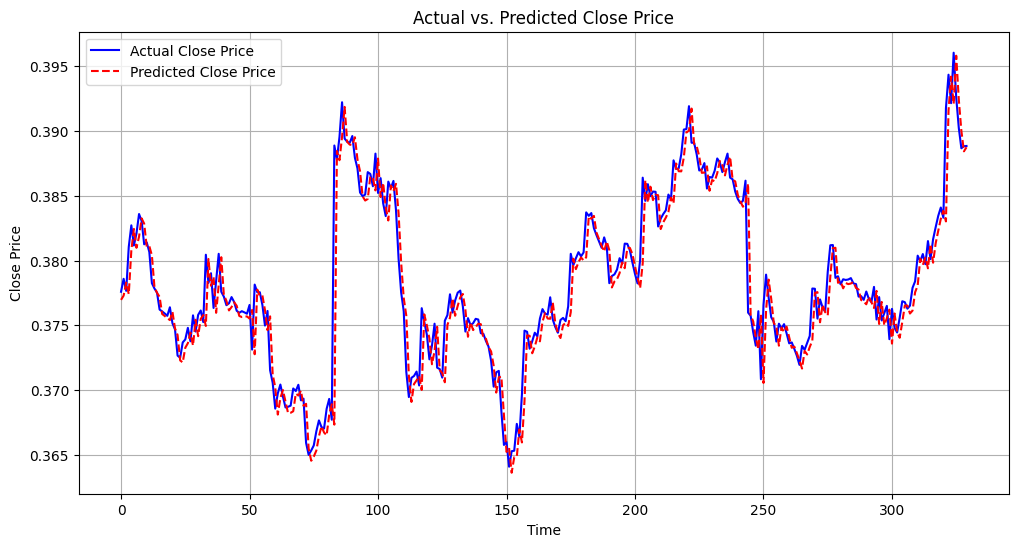

3124/3124 [==============================] - 34s 11ms/step
R^2 value for test  GeneratedEURUSD 
0.9996857610719107


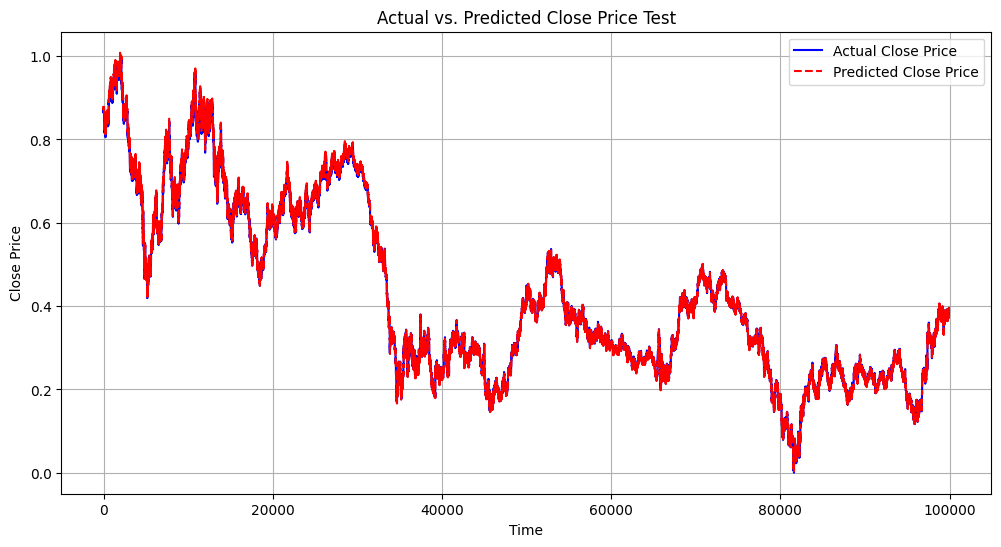

GeneratedGBPUSD 
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 60, 200)           161600    
                                                                 
 lstm_13 (LSTM)              (None, 60, 200)           320800    
                                                                 
 lstm_14 (LSTM)              (None, 60, 200)           320800    
                                                                 
 lstm_15 (LSTM)              (None, 200)               320800    
                                                                 
 dense_6 (Dense)             (None, 150)               30150     
                                                                 
 dropout_3 (Dropout)         (None, 150)  

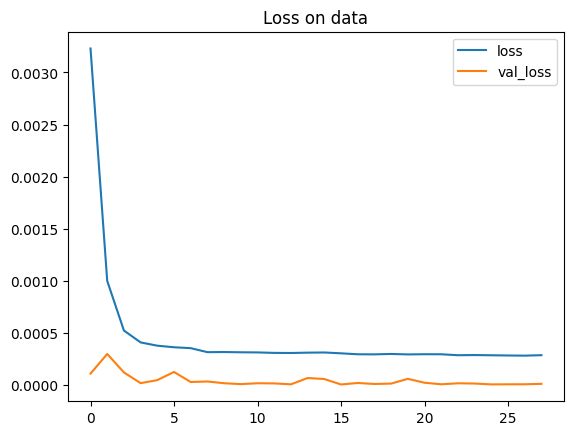

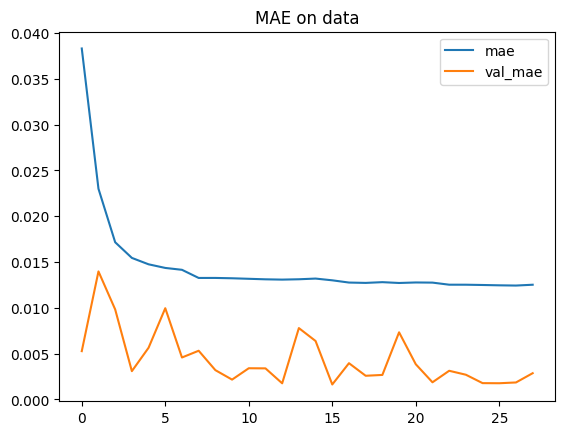

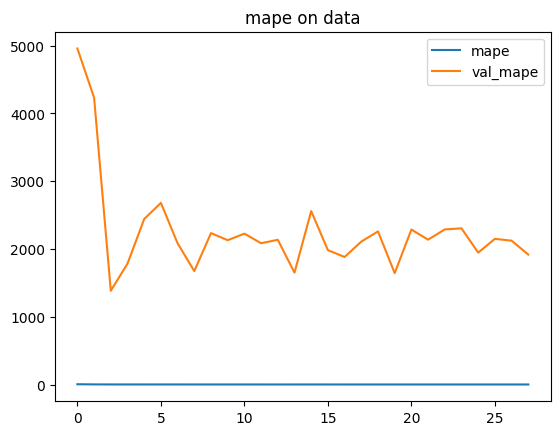

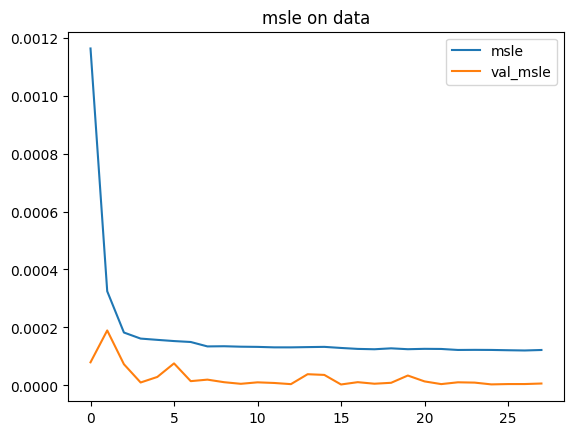

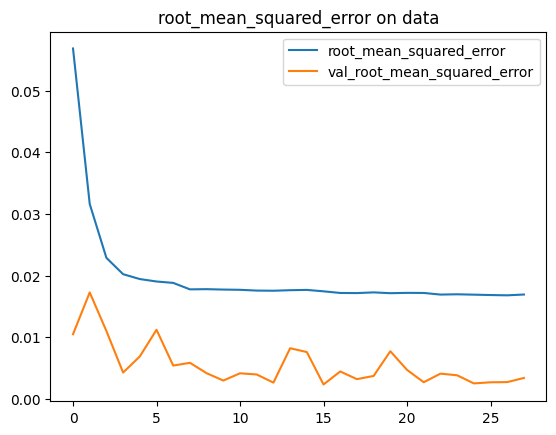

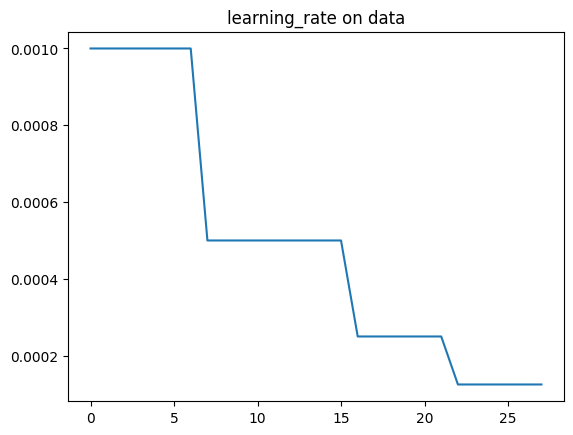

11/11 [==============================] - 1s 24ms/step
R^2 value for  GeneratedGBPUSD 
0.9070833456097679


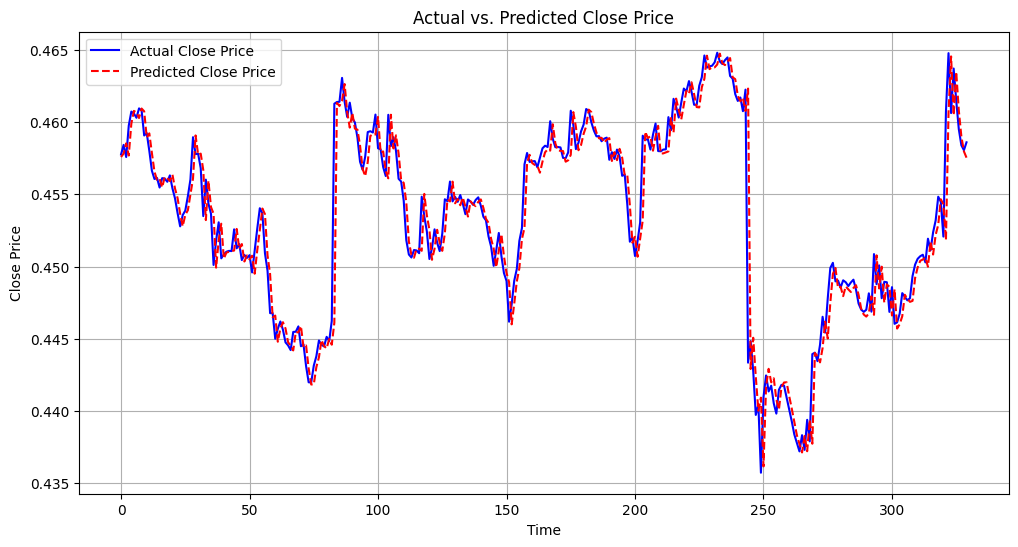

3124/3124 [==============================] - 39s 12ms/step
R^2 value for test  GeneratedGBPUSD 
0.999801404719564


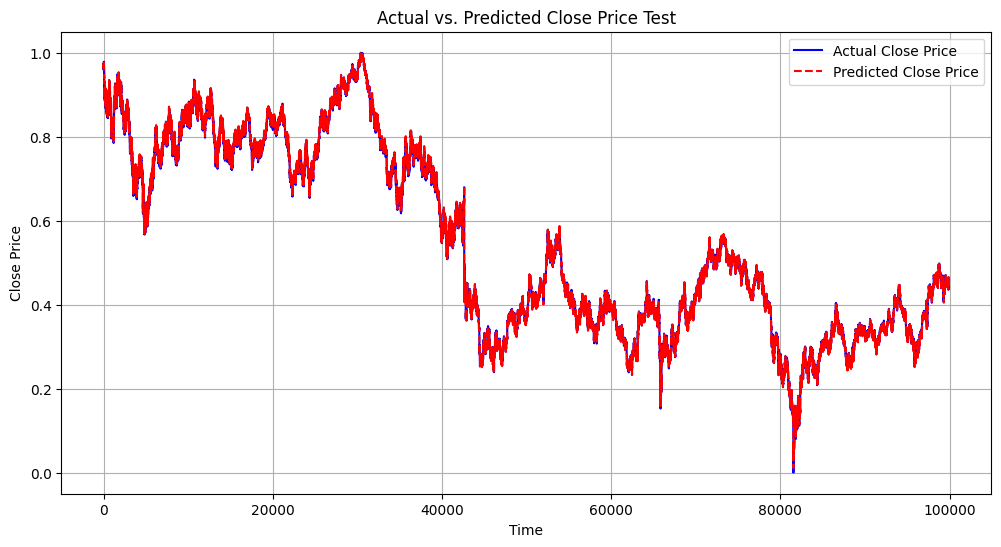

GeneratedNZDUSD 
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 200)           161600    
                                                                 
 lstm_17 (LSTM)              (None, 60, 200)           320800    
                                                                 
 lstm_18 (LSTM)              (None, 60, 200)           320800    
                                                                 
 lstm_19 (LSTM)              (None, 200)               320800    
                                                                 
 dense_8 (Dense)             (None, 150)               30150     
                                                                 
 dropout_4 (Dropout)         (None, 150)  

In [12]:
for i in range(len(train_dfs)):
  m_label = file_target[i].replace("dbot.csv","")
  train_df = train_dfs[i]
  train_df_test = train_dfs_test[i]
  print(m_label)
  SEQ_LEN = 60             # length of input sequence (timesteps). Typical choices: 30, 60, 90
  n_rows, n_features = train_df.values.shape
  scaler = MinMaxScaler(feature_range=(0, 1))
  #scaler = StandardScaler()
  s = scaler.fit_transform(train_df.values[:,-1:])
  s1 = scaler.transform(train_df_test.values[:,-1:])

  X, y = create_sequences(s, SEQ_LEN)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
  X1, y1 = create_sequences(s, SEQ_LEN)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

  n_samples = X.shape[0]

  joblib.dump(scaler, m_label + 'scaler.joblib')



  y = y.reshape((y.shape[0],y.shape[1],1))

  y1 = y1.reshape((y1.shape[0],y1.shape[1],1))


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
  X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)

  seq_len = X_train.shape[1]
  n_features = X_train.shape[2]
  output_dim = y_train.shape[1]

  i = Input(shape=(seq_len, n_features))
  X = LSTM(200, return_sequences=True)(i)
  X = LSTM(200, return_sequences=True)(X)
  X = LSTM(200, return_sequences=True)(X)
  X = LSTM(200)(X)
  #X = Dropout(0.5)(X)
  X = Dense(150, activation="relu")(X)
  X = Dropout(0.25)(X)
  X = Dense(output_dim)(X)

  model = Model(i, X)
  model.summary()

  es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
  mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
  r = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    #batch_size=2048,
    callbacks=[es, rlr, mc ],
    verbose=2

  )

  plt.title("Loss on data")
  plt.plot(r.history['loss'], label="loss")
  plt.plot(r.history['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.title("MAE on data")
  plt.plot(r.history['mae'], label="mae")
  plt.plot(r.history['val_mae'], label="val_mae")
  plt.legend()
  plt.show()

  plt.title("mape on data")
  plt.plot(r.history['mape'], label="mape")
  plt.plot(r.history['val_mape'], label="val_mape")
  plt.legend()
  plt.show()

  plt.title("msle on data")
  plt.plot(r.history['msle'], label="msle")
  plt.plot(r.history['val_msle'], label="val_msle")
  plt.legend()
  plt.show()

  plt.title("root_mean_squared_error on data")
  plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
  plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
  plt.legend()
  plt.show()

  plt.title("learning_rate on data")
  plt.plot(r.history['lr'], label="loss")
  plt.show()

  best_model = load_model(m_label + 'lstm_best.keras')
  y_pred = best_model.predict(X_test)
  print("R^2 value for ", m_label)
  print(r2_score(y_test.reshape((len(y_test),1)), y_pred.reshape((len(y_pred),1))))

  plt.figure(figsize=(12, 6))
  plt.plot(y_test[:, -1], label='Actual Close Price', color='blue')
  plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
  plt.title('Actual vs. Predicted Close Price')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.savefig('actual_vs_predicted.png')
  plt.show()

  y_pred = best_model.predict(X1)
  print("R^2 value for test ", m_label)
  print(r2_score(y1.reshape((len(y1),1)), y_pred.reshape((len(y_pred),1))))

  plt.figure(figsize=(12, 6))
  plt.plot(y1[:, -1], label='Actual Close Price', color='blue')
  plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
  plt.title('Actual vs. Predicted Close Price Test')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.savefig('actual_vs_predicted.png')
  plt.show()



In [ ]:
!zip -r * archive.zip

In [ ]:
"""
best_model = load_model(m_label + 'lstm_best.keras')
    y_pred = best_model.predict(X_test)
    print("R^2 value for ", m_label)
    print(r2_score(y_test.reshape((len(y_test),1)), y_pred.reshape((len(y_pred),1))))

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, -1], label='Actual Close Price', color='blue')
    plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
    plt.title('Actual vs. Predicted Close Price')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('actual_vs_predicted.png')
    plt.show()

    y_pred = best_model.predict(X1)
    print("R^2 value for test ", m_label)
    print(r2_score(y1.reshape((len(y1),1)), y_pred.reshape((len(y_pred),1))))

    plt.figure(figsize=(12, 6))
    plt.plot(y1[:, -1], label='Actual Close Price', color='blue')
    plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
    plt.title('Actual vs. Predicted Close Price Test')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('actual_vs_predicted.png')
    plt.show()
"""

In [ ]:
dir_contents = os.listdir(".")
t_symbol = joblib.load("symbol.joblib")
# Filter the list to include only files, not directories
# os.path.join is used to create a full path for isfile() to check
files = [item for item in dir_contents]

file_target = []

for filename in files:
    for t_s in t_symbol:
        if t_s in filename and "lstm_best.keras" in filename:
            print(filename)
            #file_target.append(filename)
print("----------------------------------------------------")

print(len(file_target))


In [ ]:


best_model = load_model(MODEL_SAVE_PATH)

In [ ]:
y_pred = best_model.predict(X_test)
print(y_pred)

In [ ]:
print(y_test)

In [ ]:

r2_score(y_test.reshape((len(y_test),1)), y_pred.reshape((len(y_pred),1)))

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

In [ ]:
# Save this as plot_forecast.py and run where your model, x_test, y_test (and optional scalers) are available.

import numpy as np
import matplotlib.pyplot as plt

def ensure_2d_preds(preds):
    """Normalize model.predict outputs to shape (n_samples, n_features)."""
    preds = np.asarray(preds)
    if preds.ndim == 3:
        # common case: (n_samples, 1, n_features) or (n_samples, seq_len, n_features)
        # we assume model outputs final-step predictions if seq_len>1
        if preds.shape[1] == 1:
            preds = preds[:, 0, :]
        else:
            preds = preds[:, -1, :]
    elif preds.ndim == 1:
        preds = preds.reshape(-1, 1)
    return preds

def plot_test_vs_pred_close(y_test, preds, output_index=-1, figsize=(12,5), savepath=None):
    """
    Plot actual vs predicted for the 'close' column (default last column).
    y_test: (n, n_features)
    preds: (n, n_features)
    """
    y_test = np.asarray(y_test)
    preds = np.asarray(preds)
    # normalize shapes
    preds = ensure_2d_preds(preds)

    actual_close = y_test[:, output_index]
    pred_close   = preds[:, output_index]

    plt.figure(figsize=figsize)
    plt.plot(actual_close, label='Actual Close')
    plt.plot(pred_close, label='Predicted Close')
    plt.xlabel('Time (test index)')
    plt.ylabel('Close price')
    plt.title('Actual vs Predicted Close Price (test set)')
    plt.legend()
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def recursive_forecast(model, last_window, n_steps=2000):
    """
    Do recursive multi-step forecasting:
      - model.predict expects input shape (1, window_len, n_features)
      - last_window: shape (window_len, n_features)
      - returns array shape (n_steps, n_features)
    """
    last_window = last_window.reshape((len(last_window),1))
    if last_window.ndim != 2:
        raise ValueError("last_window must be 2D: (window_len, n_features)")

    window_len, n_features = last_window.shape
    history = last_window.copy()
    preds = []
    for i in range(n_steps):
        x_in = history.reshape(1, window_len, n_features)
        p = model.predict(x_in)
        p = ensure_2d_preds(p)[0]  # shape: (n_features,)
        preds.append(p)
        # slide window
        history = np.vstack([history[1:], p.reshape(1, n_features)])
    return np.vstack(preds)  # shape (n_steps, n_features)

def plot_extended_series(y_test, future_preds, output_index=-1, figsize=(14,5), savepath=None):
    """
    Plot the test-close series and appended future predictions as one continuous line.
    """
    actual_close = np.asarray(y_test)[:, output_index]
    future_close = np.asarray(future_preds)[:, output_index]
    combined = np.concatenate([actual_close, future_close])

    plt.figure(figsize=figsize)
    plt.plot(combined, label='Actual (test) + Forecast (future)')
    # mark border between known and forecast
    split_index = len(actual_close)
    plt.axvline(split_index - 0.5, linestyle='--', linewidth=1)
    plt.text(split_index + 5, combined[split_index], ' Forecast starts', va='center')
    plt.xlabel('Time (index)')
    plt.ylabel('Close price')
    plt.title(f'Actual Close (test) and {len(future_close)} Step Forecast')
    plt.legend()
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()



In [ ]:
# ------------------------------------------------------------
# USAGE (example)
# ------------------------------------------------------------
# Assumptions:
# - x_test shape = (n_samples, window_len, n_features) e.g. (6247, 48, 4)
# - y_test shape = (n_samples, n_features) e.g. (6247, 4)
# - model.predict(x_test) -> (n_samples, n_features) (or shape convertible)
#
# Optional:
# - scaler_X (used during training on inputs) or scaler_y (used on outputs).
#   If present, inverse_transform predictions and y_test before plotting.
#
# Replace these names with your actual variables present in the workspace.

# Example (uncomment and run where variables exist):
preds_test = best_model.predict(X_test)
preds_test = ensure_2d_preds(preds_test)

# # 1) plot actual vs predicted (test)
plot_test_vs_pred_close(y_test, preds_test, output_index=-1, savepath='test_vs_pred.png')


In [ ]:
#
# # 2) recursive forecast next 2000 values starting from last input window:
last_window = X_test[-1].reshape((len(X_test[-1]),1))   # shape (window_len, n_features)
future_preds = recursive_forecast(best_model, last_window, n_steps=200)
future_preds_inv = future_preds

# # 3) plot extended series (append future close to test close)
plot_extended_series(y_test, future_preds_inv, output_index=-1, savepath='extended_forecast.png')
#
# # Optional: save future_preds_inv to disk
# # np.save('future_preds.npy', future_preds_inv)